In [24]:
%load_ext autoreload
%autoreload 2
import os, sys
# os.environ['PROXY_URL'] = ''
from trade.helpers.Context import Context
from trade.helpers.helper import change_to_last_busday, is_USholiday, retrieve_timeseries, find_split_dates_within_range
from scipy.stats import percentileofscore
from _strategy.trend.bbands import LongBBandsTrend, LongBBandsTrend_SL
import pandas as pd
from pandas.tseries.offsets import BDay
from dateutil.relativedelta import relativedelta
from datetime import datetime
import yfinance as yf
import numpy as np
from scipy.stats import norm, skew, kurtosis
from trade.helpers.Logging import setup_logger
from trade.assets.Stock import Stock
import matplotlib.pyplot as plt
import pandas_datareader.data as web
import pandas_ta as ta
from trade.backtester_.utils.aggregators import dd, mdd, cagr
from wfa.aggregator import Aggregator, MonteCarloBacktest, BaseAggregator, median_dd, EVBOptionAggregator
from wfa.utils import load_result_dict, results_dict, get_equity_tick
import statsmodels.api as sm
from dbase.DataAPI.ThetaData import retrieve_quote, list_contracts, retrieve_eod_ohlc
import statsmodels.formula.api as smf  
from EventDriven.riskmanager.utils import add_skip_columns
from scipy.stats.mstats import winsorize
logger = setup_logger('Opt_WFA_Analysis')
pd.options.plotting.backend = 'plotly'
pd.options.display.float_format = '{:,.2f}'.format

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## To check:
- Sanity Checks:
    - Yearly aggregates
    - Aggregates
    - Trades
    - Comparing trades and equity moves
    - Monte Carlo Backtest


## Disturbing Findings:
- Why are some trades going to 0? I'm guessing slippage. (Add to data notes)

## Investigate:
- why is `ZSCORE2_DTE270_ROLL120` performing so well. Obviously from scaling, but check trades and make sure they make sense
    - Esp. 2024, why's it so good?
    - Investigate 2020 & 2025, SMOOTH vs ACTUAL, why do they have significant diff?

In [156]:
load_result_dict('OPTION', 'BASE', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/base.pkl')
load_result_dict('OPTION', 'ZSCORE_1NORM', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/vol_zscore_1scale.pkl')
load_result_dict('OPTION', 'ZSCORE_2NORM', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/vol_zscore_2scale.pkl')
load_result_dict('OPTION', 'DTE270_ROLL120', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/dte_270_roll_120.pkl')
load_result_dict('OPTION', 'BASE_ROLL120', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/base_roll_120.pkl')
load_result_dict('OPTION', 'ZSCORE2_DTE270_ROLL120', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/zscore2_dte180_roll120.pkl')
load_result_dict('OPTION', 'CHOICE_SMOOTH', '/Users/chiemelienwanisobi/cloned_repos/QuantTools/EventDriven/demos/opt_wfa/zscore2_dte180_roll120_smooth.pkl')


In [157]:

        


option_aggregator_base = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'BASE')

option_aggregator_zscore1 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'ZSCORE_1NORM')

option_aggregator_zscore2 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'ZSCORE_2NORM')

option_aggregator_dte270_roll120 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'DTE270_ROLL120')

option_aggregator_base_roll120 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'BASE_ROLL120')

option_aggregator_zscore2_dte270_roll120 = EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'ZSCORE2_DTE270_ROLL120')

option_aggregator_smooth =  EVBOptionAggregator(
                        optimization = 'OPTION', 
                        target = 'CHOICE_SMOOTH')

aggregators = [
    option_aggregator_base,
    option_aggregator_zscore1,
    option_aggregator_zscore2,
    option_aggregator_dte270_roll120,
    option_aggregator_base_roll120,
    option_aggregator_zscore2_dte270_roll120,
    option_aggregator_smooth
]
aggregators

## MONTE CARLO SIMULATION

In [141]:
carlo_config = {
'ewm_span': 3,
'size': 252*2, # Number of days to simulate 
'num_simulations': 1000, # Number of simulations to run
'cutoff': 0.5, # Cutoff return for ruin prob
'initial_equity': 20_000, # Initial equity to start with
'log': True, # Whether to use log returns
'skip_window': 15, # Window for skip calcs
'skip_thresh': 2.5, # zscore thresh for skips,
'plot_ewm_span': 8
}
carlo_config

{'ewm_span': 3,
 'size': 504,
 'num_simulations': 1000,
 'cutoff': 0.5,
 'initial_equity': 20000,
 'log': True,
 'skip_window': 15,
 'skip_thresh': 2.5,
 'plot_ewm_span': 8}

### SMOOTHED EQ

In [160]:
pd.options.display.float_format = '{:,.2f}'.format
smooth_eq_full = pd.DataFrame()
for agg in aggregators:

    historical_eq = agg._equity['Total']
    smoothed_eq = agg._equity['Total'].ewm(span =carlo_config['ewm_span']).mean()

    # historical_returns = smoothed_eq.pct_change(periods = 1).dropna()
    historical_returns = np.log(smoothed_eq/smoothed_eq.shift(1)).dropna()
    monte_smooth = MonteCarloBacktest(returns = historical_returns, 
                            initial_price  = carlo_config['initial_equity'], 
                            size = carlo_config['size'], 
                            num_simulations = carlo_config['num_simulations'],
                            log = carlo_config['log'])
    summary_smooth = monte_smooth.summary(carlo_config['cutoff'])
    summary_smooth.name = agg.target
    smooth_eq_full = pd.concat([smooth_eq_full, summary_smooth], axis = 1)

smooth_eq_full = smooth_eq_full.T
float_cols = [
    'CAGR/DD',
    'Median Skew',
    'Median $ Profit',
    'Median Var95',
    'Median Var05',
    'Best Case Final Equity (95%)',
    'Worst Case Final Equity (05%)'
]
smooth_eq_full[float_cols] = smooth_eq_full[float_cols].astype(float).round(2)
smooth_eq_full = smooth_eq_full.T
## Add median CAGR
## Median Vol
## Median Sharpe
## Median Skew

In [161]:
smooth_eq_full

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Ruin,19.20%,7.00%,14.10%,17.80%,19.30%,17.30%,1.20%
Median Drawdown,-56.87%,-43.12%,-53.69%,-56.79%,-56.57%,-56.49%,-33.38%
Worst Drawdown,-96.58%,-82.76%,-93.04%,-94.57%,-94.88%,-94.67%,-87.25%
Median Vol Annualized,81.07%,55.18%,76.82%,81.17%,80.69%,82.71%,47.23%
Median $ Profit,"58,944.23","32,028.09","62,641.36","55,437.60","49,436.18","73,816.73","51,185.00"
Median Return,291.81%,159.21%,314.92%,280.54%,248.44%,368.44%,256.04%
Median CAGR,169.38%,99.60%,180.82%,163.73%,147.40%,206.66%,151.30%
Median Skew,0.71,0.41,0.56,0.76,0.77,0.68,0.80
CAGR/DD,2.98,2.31,3.37,2.88,2.61,3.66,4.53
Prob>0,87.80%,88.50%,90.20%,88.20%,85.90%,90.90%,96.40%


### WINSORIZE & SKIP ADJUSTED

In [162]:
full_monte_win_skip = pd.DataFrame()
for agg in aggregators:
    equity2 = agg._equity.copy()
    equity2 = add_skip_columns(
        equity2, 
        'IGNORE',
        ['Total'],
        carlo_config['skip_window'],
        carlo_config['skip_thresh']

    )

    equity2['ffwd_total'] = equity2.Total
    equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
    equity2.ffwd_total.fillna(method = 'ffill', inplace = True)


    log_returns = np.log(equity2.ffwd_total/ equity2.ffwd_total.shift(1)).dropna()
    clipped_returns = winsorize(log_returns, limits=[0.01, 0.01])


    monte_winsorize_skip = MonteCarloBacktest(returns = clipped_returns, 
                            initial_price  = carlo_config['initial_equity'], 
                            size = carlo_config['size'], 
                            num_simulations = carlo_config['num_simulations'],
                            log = carlo_config['log'])
    summary_winsorize_skip = monte_winsorize_skip.summary(carlo_config['cutoff'])
    summary_winsorize_skip.name = agg.target
    full_monte_win_skip = pd.concat([full_monte_win_skip, summary_winsorize_skip], axis = 1)

full_monte_win_skip = full_monte_win_skip.T
full_monte_win_skip[float_cols] = full_monte_win_skip[float_cols].astype(float).round(2)
full_monte_win_skip = full_monte_win_skip.T
full_monte_win_skip

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Ruin,26.50%,9.00%,25.50%,27.80%,26.10%,25.30%,8.70%
Median Drawdown,-62.56%,-44.99%,-61.43%,-63.86%,-61.74%,-61.83%,-44.31%
Worst Drawdown,-97.99%,-88.88%,-97.59%,-98.08%,-96.77%,-94.42%,-84.10%
Median Vol Annualized,90.61%,58.34%,89.09%,90.60%,88.96%,93.27%,59.11%
Median $ Profit,"50,858.61","35,968.54","57,956.40","48,682.45","49,893.94","59,665.81","41,013.96"
Median Return,250.74%,180.05%,290.58%,244.25%,244.41%,296.83%,205.46%
Median CAGR,148.58%,111.12%,168.77%,145.23%,145.32%,171.88%,124.85%
Median Skew,0.52,0.44,0.46,0.67,0.54,0.64,0.59
CAGR/DD,2.38,2.47,2.75,2.27,2.35,2.78,2.82
Prob>0,84.40%,88.50%,84.00%,81.90%,84.60%,86.50%,90.40%


## STRATEGY STATS

In [ ]:
stats_interest = [
    'Duration',
    'Exposure Time [%]',
    'Equity Final [$]',
    'Return [%]',
    'Median Daily Return [%]',
    'VaR 95% [%]',
    'VaR 05% [%]',
    'CAGR [%]',
    'Volatility Ann. [%]',
    'Sharpe Ratio',
    'Log Return Skew',
    'Max. Drawdown [%]',
    'Avg. Drawdown [%]',
    'Avg Dradown Duration',
    '# Trades',
    'Best Trade [%]',
    'Worst Trade [%]',
    'Avg. Winning Trade [%]',
    'Avg. Losing Trade [%]',
    'Avg Win Trade Duration',
    'Avg Lose Duration',
    'Expectancy [%]',

]

agg_stats = pd.DataFrame()
for agg in aggregators:
    aggregate = agg.aggregate()
    add_stats = [ x for x in aggregate.index if x.endswith(' Return [%]')]
    agg_stats[agg.target] = aggregate[stats_interest + add_stats]


## What's calmar & sortino ratio

In [175]:
agg_stats
# aggregators[-1].daily_rtrns().median()
# aggregators[-1].aggregate()

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Duration,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00
Exposure Time [%],100.00,100.00,100.00,100.00,100.00,100.00,100.00
Equity Final [$],"3,123,689.73","985,139.88","4,208,470.69","4,912,997.00","2,725,686.51","11,139,994.62","3,600,435.93"
Return [%],"15,983.32","4,910.03","21,540.93","24,791.16","13,785.15","56,594.66","18,231.45"
Median Daily Return [%],0.1537%,0.1313%,0.2248%,0.1892%,0.1338%,0.2874%,0.2063%
VaR 95% [%],-13.64%,-9.32%,-13.94%,-12.97%,-13.29%,-13.59%,-6.52%
VaR 05% [%],16.20%,11.14%,15.29%,16.64%,16.77%,16.69%,7.46%
CAGR [%],86.35,61.54,93.25,96.60,83.03,117.46,89.36
Volatility Ann. [%],209.59,138.60,193.38,199.18,211.38,207.17,83.28
Sharpe Ratio,1.23,0.99,1.22,1.22,1.21,1.27,1.17


In [171]:
agg_stats

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Duration,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00,2979 days 00:00:00
Exposure Time [%],95.47,95.47,95.47,97.26,95.47,97.26,97.26
Equity Final [$],"3,123,689.73","985,139.88","4,208,470.69","4,912,997.00","2,725,686.51","11,139,994.62","3,600,435.93"
Return [%],"15,983.32","4,910.03","21,540.93","24,791.16","13,785.15","56,594.66","18,231.45"
Median Daily Return [%],0.0000%,0.0000%,0.0000%,0.0000%,0.0000%,0.0594%,0.1249%
VaR 95% [%],-13.22%,-8.84%,-13.08%,-12.80%,-12.75%,-13.05%,-6.44%
VaR 05% [%],15.18%,10.50%,14.74%,16.06%,16.03%,15.76%,7.28%
CAGR [%],86.35,61.54,93.25,96.60,83.03,117.46,89.36
Volatility Ann. [%],209.64,138.62,193.42,199.20,211.42,207.20,83.28
Sharpe Ratio,1.23,0.99,1.22,1.22,1.21,1.27,1.17


## YEARLY STATISTICS DRILL DOWN

In [163]:
year = 2022
yearly_journal = pd.DataFrame()
for agg in aggregators:
    year_info = agg.yearly_agg().loc[year]
    year_info.name = agg.target
    yearly_journal[agg.target] = year_info
yearly_journal

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Return [%],-0.25,-0.13,-0.23,-0.40,-0.25,-0.39,-0.38
Vol Annualized [%],1.20,0.86,1.21,0.51,1.15,0.52,0.26
Sharpe,0.34,0.24,0.36,-0.86,0.30,-0.79,-1.89
Max DrawDown [%],-49.95,-40.57,-49.89,-41.73,-48.10,-42.26,-40.85
Max DrawDown Duration,277 days 00:00:00,277 days 00:00:00,277 days 00:00:00,361 days 00:00:00,277 days 00:00:00,361 days 00:00:00,361 days 00:00:00
#Trades,18.00,18.00,18.00,23.00,18.00,23.00,23.00
Win Rate [%],22.22,22.22,22.22,13.04,22.22,13.04,13.04
Expectancy [%],-19.59,-15.01,-19.13,-21.06,-19.28,-20.23,-21.12
95 Quantile ($),"59,396.25","25,630.33","90,204.48","35,111.38","44,341.50","69,610.32","11,686.55"
5 Quantile ($),"-66,684.25","-20,259.38","-94,079.40","-54,779.95","-50,754.75","-95,299.36","-17,676.51"


In [165]:
year = 2020
yearly_journal = pd.DataFrame()
for agg in aggregators:
    year_info = agg.yearly_agg().loc[year]
    year_info.name = agg.target
    yearly_journal[agg.target] = year_info
yearly_journal

,BASE,ZSCORE_1NORM,ZSCORE_2NORM,DTE270_ROLL120,BASE_ROLL120,ZSCORE2_DTE270_ROLL120,CHOICE_SMOOTH
Return [%],4.12,3.08,4.66,4.21,3.70,5.52,2.49
Vol Annualized [%],2.05,1.32,1.95,1.95,2.03,2.15,0.82
Sharpe,1.76,1.68,1.81,1.81,1.73,1.89,1.88
Max DrawDown [%],-63.47,-41.38,-61.21,-63.52,-63.27,-57.75,-41.64
Max DrawDown Duration,80 days 00:00:00,80 days 00:00:00,80 days 00:00:00,55 days 00:00:00,119 days 00:00:00,113 days 00:00:00,120 days 00:00:00
#Trades,38.00,38.00,38.00,44.00,35.00,43.00,43.00
Win Rate [%],63.16,60.53,63.16,67.44,57.14,67.44,62.79
Expectancy [%],46.48,46.02,47.25,48.03,46.08,48.79,32.34
95 Quantile ($),"33,680.15","17,200.77","46,524.75","64,209.55","28,614.50","90,776.32","19,467.61"
5 Quantile ($),"-33,380.00","-14,244.38","-45,606.68","-69,683.24","-28,291.42","-86,386.25","-22,587.00"


## PLOT EQUITY, DD & HEATMAP

In [130]:
all_eq = pd.DataFrame()
smoothen = True
for agg in aggregators:
    agg_eq = agg._equity.Total
    if smoothen:
        agg_eq = agg_eq.ewm(span = carlo_config['plot_ewm_span']).mean()
    all_eq[agg.target] = agg_eq

all_eq.ffill().plot()

In [137]:
drawdown_all = pd.DataFrame()
for agg in aggregators:
    drawdown_all[agg.target] = agg.dd()
drawdown_all.plot()

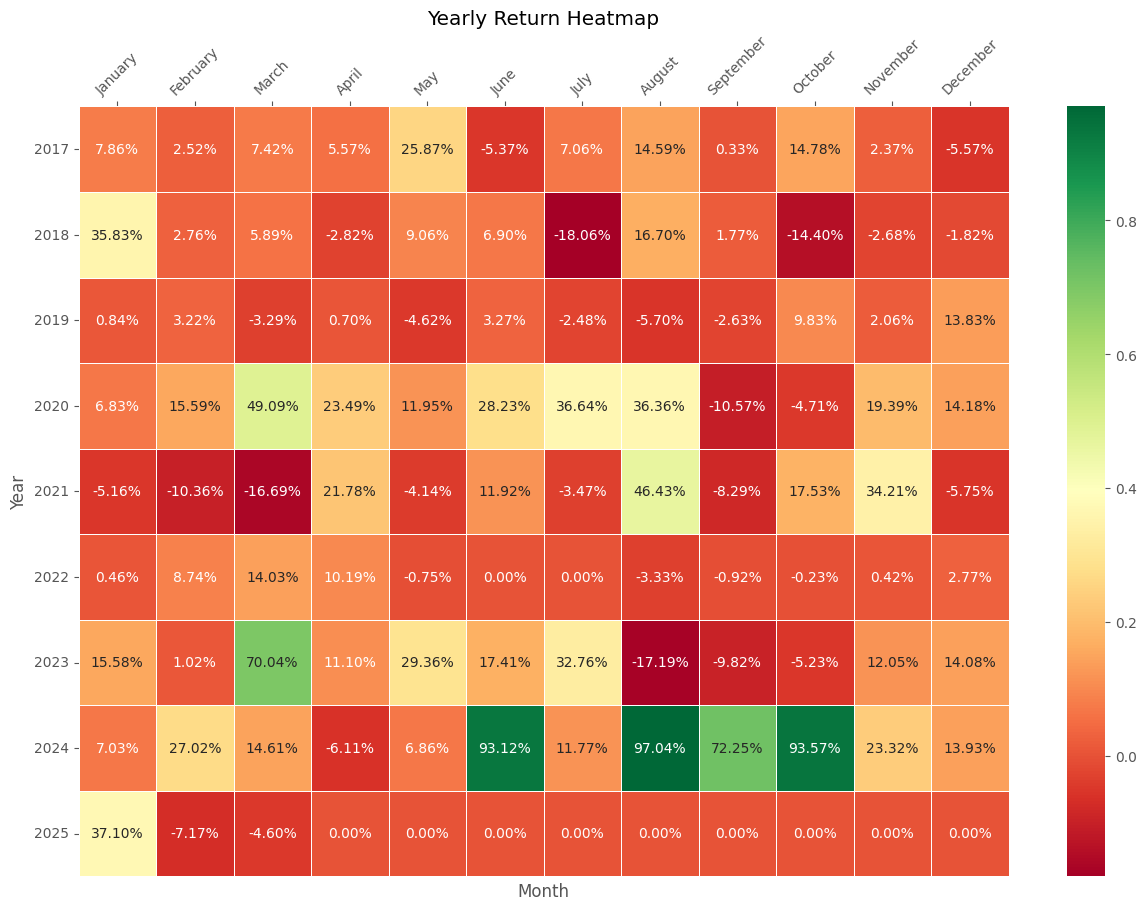

,January,February,March,April,May,June,July,August,September,October,November,December
Year,,,,,,,,,,,,
2017,0.08,0.03,0.07,0.06,0.26,-0.05,0.07,0.15,0.00,0.15,0.02,-0.06
2018,0.36,0.03,0.06,-0.03,0.09,0.07,-0.18,0.17,0.02,-0.14,-0.03,-0.02
2019,0.01,0.03,-0.03,0.01,-0.05,0.03,-0.02,-0.06,-0.03,0.10,0.02,0.14
2020,0.07,0.16,0.49,0.23,0.12,0.28,0.37,0.36,-0.11,-0.05,0.19,0.14
2021,-0.05,-0.10,-0.17,0.22,-0.04,0.12,-0.03,0.46,-0.08,0.18,0.34,-0.06
2022,0.00,0.09,0.14,0.10,-0.01,0.00,0.00,-0.03,-0.01,-0.00,0.00,0.03
2023,0.16,0.01,0.70,0.11,0.29,0.17,0.33,-0.17,-0.10,-0.05,0.12,0.14
2024,0.07,0.27,0.15,-0.06,0.07,0.93,0.12,0.97,0.72,0.94,0.23,0.14
2025,0.37,-0.07,-0.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
option_aggregator_zscore1.yearly_performance(True)

## TRADES COMP

#### Finding Notes

- Index 31 `&L:TSLA20210716C1990&S:TSLA20210716C1995`: A lot of pretty erratic moves in underlying Midpoint. 
- Index 25 `&L:TSLA20210319C1590&S:TSLA20210319C1600`: Similar issue to Index 31
- Index 25: `&L:TSLA20210319C945&S:TSLA20210319C950`: Sizing discrepancy significant driver of change
- Index 19: `&L:AAPL20201218C315&S:AAPL20201218C320`: Volatility Driving this

In [214]:
smooth_rm =option_aggregator_smooth.backtesters[7].portfolio.risk_manager
rm =option_aggregator_zscore2_dte270_roll120.backtesters[7].portfolio.risk_manager
pm =option_aggregator_smooth.backtesters[7].portfolio
trades_df = rm.unadjusted_signals
trades_df[trades_df.Ticker == 'NVDA']
rm.greek_limits['delta']['TSLA20200612LONG'], smooth_rm.greek_limits['delta']['TSLA20200612LONG']

(18.795239581397542, 1.796542199890148)

In [224]:
rm.sizer.signal_starting_cash['TSLA20200612LONG'], smooth_rm.sizer.signal_starting_cash['TSLA20200612LONG'] 


(1.689879706214999, 1.689879706214999)

In [235]:
smooth_pnl = option_aggregator_smooth.backtesters[7].portfolio.trades.copy()[['TradeID', 'PnL', 'EntryPrice', 'ExitPrice', 'EntryQuantity']]
pnl = option_aggregator_zscore2_dte270_roll120.backtesters[7].portfolio.trades.copy()[['EntryTime','ExitTime','TradeID', 'PnL', 'EntryPrice', 'ExitPrice', 'EntryQuantity', 'SignalID', 'Ticker']]
pnl = pnl.merge(smooth_pnl, on='TradeID', suffixes=('', '_smooth'))
pnl

,EntryTime,ExitTime,TradeID,PnL,EntryPrice,ExitPrice,EntryQuantity,SignalID,Ticker,PnL_smooth,EntryPrice_smooth,ExitPrice_smooth,EntryQuantity_smooth
0,2020-01-06,2020-03-04,&L:META20200918C270&S:META20200918C280,"-2,293.70",119.91,56.10,34,META20200106LONG,META,"-1,751.58",106.45,55.98,33
1,2020-01-06,2020-03-16,&L:AAPL20200918C380&S:AAPL20200918C390,"-1,488.92",100.51,79.33,59,AAPL20200106LONG,AAPL,"-1,009.00",95.67,80.17,55
2,2020-01-06,2020-03-18,&L:NVDA20210115C315&S:NVDA20210115C320,"-3,617.90",105.14,98.70,281,NVDA20200106LONG,NVDA,-434.27,94.81,97.35,291
3,2020-01-06,2020-01-23,&L:TSLA20200918C490&S:TSLA20200918C500,"2,188.93",288.34,538.35,9,TSLA20200106LONG,TSLA,"1,565.14",323.38,551.36,7
4,2020-01-06,2020-03-20,&L:AMD20200717C60&S:AMD20200717C65,"-7,747.69",105.75,49.23,130,AMD20200106LONG,AMD,"-5,876.93",103.54,59.29,124
5,2020-01-10,2020-03-02,&L:COST20200717C325&S:COST20200717C330,"1,636.41",120.78,171.00,39,COST20200110LONG,COST,"1,318.10",122.65,162.24,37
6,2020-01-17,2020-01-31,&L:SBUX20210115C97.5&S:SBUX20210115C100,"-3,138.87",101.86,54.85,62,SBUX20200117LONG,SBUX,"-2,769.60",100.91,56.55,58
7,2020-01-23,2020-02-05,&L:TSLA20200918C755&S:TSLA20200918C760,"3,719.13",102.46,184.43,48,TSLA20200106LONG,TSLA,"3,831.29",109.72,223.95,37
8,2020-01-27,2020-03-17,&L:NFLX20200918C430&S:NFLX20200918C435,925.63,99.37,120.28,54,NFLX20200127LONG,NFLX,-283.00,104.59,105.36,50
9,2020-02-04,2020-03-02,&L:AMZN20200918C2065&S:AMZN20200918C2070,641.94,138.46,168.58,25,AMZN20200204LONG,AMZN,381.66,134.88,160.66,24


In [244]:

pnl['ABS_Pct_Diff'] = (pnl.PnL - pnl.PnL_smooth).abs() / pnl.PnL.abs()
pnl['abs_entry_price_diff'] = (pnl.EntryPrice - pnl.EntryPrice_smooth).abs() / pnl.EntryPrice.abs()
pnl['abs_exit_price_diff'] = (pnl.ExitPrice - pnl.ExitPrice_smooth).abs() / pnl.ExitPrice.abs()
pnl.sort_values(by=['abs_entry_price_diff', 'abs_entry_price_diff'], ascending=[False, True])[['TradeID', 'PnL', 'PnL_smooth','ABS_Pct_Diff','EntryPrice','EntryPrice_smooth','abs_entry_price_diff','ExitPrice','ExitPrice_smooth']]

,TradeID,PnL,PnL_smooth,ABS_Pct_Diff,EntryPrice,EntryPrice_smooth,abs_entry_price_diff,ExitPrice,ExitPrice_smooth
20,&L:AMZN20210219C3000&S:AMZN20210219C3020,"38,944.44","24,127.81",0.38,109.24,262.08,1.40,692.81,793.43
10,&L:TSLA20200918C895&S:TSLA20200918C900,"-3,097.40","-6,570.46",1.12,111.27,212.52,0.91,41.94,52.16
25,&L:TSLA20210319C1590&S:TSLA20210319C1600,"32,332.28","4,150.39",0.87,110.85,180.86,0.63,474.21,497.92
31,&L:TSLA20210716C1990&S:TSLA20210716C1995,"33,149.53",-295.97,1.01,116.65,188.84,0.62,211.91,185.89
24,&L:TSLA20210319C945&S:TSLA20210319C950,"4,605.55",516.04,0.89,152.00,195.66,0.29,279.40,251.99
35,&L:NVDA20210618C660&S:NVDA20210618C680,"-41,961.88","-113,392.75",1.70,372.77,465.85,0.25,341.23,308.41
19,&L:AAPL20201218C315&S:AAPL20201218C320,"1,295.43",-222.54,1.17,117.14,142.36,0.22,138.69,141.70
11,&L:COST20201016C370&S:COST20201016C375,153.65,220.67,0.44,112.79,88.81,0.21,129.51,110.44
16,&L:NVDA20201218C265&S:NVDA20201218C270,"66,496.10","39,155.81",0.41,119.39,138.66,0.16,301.69,298.63
39,&L:AMD20210618C100&S:AMD20210618C105,"4,384.88","2,693.55",0.39,101.97,115.14,0.13,143.56,147.86


In [251]:
pnl
index = 20
_id, _entry, _exit = pnl.iloc[index][['TradeID', 'EntryTime', 'ExitTime']]
tick = pnl.iloc[index]['Ticker']
data = rm.position_data[_id].copy()
data['ewm_1'] = data['Midpoint'].ewm(span=1).mean()
data['ewm_3'] = data['Midpoint'].ewm(span=3).mean()
data['ewm_5'] = data['Midpoint'].ewm(span=5).mean()
data['abs_pct_ewn_3'] = (data['Midpoint'] - data['ewm_3']).abs() / data['Midpoint'].abs()
data['abs_pct_ewn_5'] = (data['Midpoint'] - data['ewm_5']).abs() / data['Midpoint'].abs()
data['ewm_3_pct_skip'] = data['abs_pct_ewn_3'] > 0.75
data['ewm_5_pct_skip'] = data['abs_pct_ewn_5'] > 0.75
data[['ewm_3_pct_skip', 'ewm_5_pct_skip']].sum()
print(_entry, _exit)
print(pnl.loc[index])
# data[['ewm_3_pct_skip', 'ewm_5_pct_skip', 'Midpoint_skip_day']][_entry:_exit].plot()
data[['Midpoint', 'ewm_1', 'ewm_3', 'ewm_5']].loc[_entry:_exit].plot(title='EWMA Smoothing of Midpoint Price')

2020-04-17 00:00:00 2020-09-01 00:00:00
EntryTime                                    2020-04-17 00:00:00
ExitTime                                     2020-09-01 00:00:00
TradeID                 &L:AMZN20210219C3000&S:AMZN20210219C3020
PnL                                                    38,944.44
EntryPrice                                                109.24
ExitPrice                                                 692.81
EntryQuantity                                                 70
SignalID                                        AMZN20200417LONG
Ticker                                                      AMZN
PnL_smooth                                             24,127.81
EntryPrice_smooth                                         262.08
ExitPrice_smooth                                          793.43
EntryQuantity_smooth                                          48
ABS_Pct_Diff                                                0.38
abs_entry_price_diff                              

In [249]:
pm.get_underlier_data(tick).rvol(
                                   ts_start = rm.pm_start_date,
                                   ts_end = rm.pm_end_date).rvol_30D[_entry:_exit].plot(title='NVDA Spot Price')

In [250]:
data[['ewm_3_pct_skip', 'ewm_5_pct_skip', 'Midpoint_skip_day']][_entry:_exit].plot()

## MISC

In [11]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator_zscore2._equity['Total']
smoothed_eq = option_aggregator_zscore2._equity['Total'].ewm(span =1).mean()

# historical_returns = smoothed_eq.pct_change(periods = 1).dropna()
historical_returns = np.log(smoothed_eq/smoothed_eq.shift(1)).dropna()
monte_smooth = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 1000,
                           log = True)
summary_smooth = monte_smooth.summary(0.5)
summary_smooth

## Add median CAGR
## Median Vol
## Median Sharpe
## Median Skew

Ruin                                      71.00%
Median Drawdown                          -98.99%
Worst Drawdown                          -100.00%
Median Vol Annualized                    196.60%
Median $ Profit                      15551254.52
Median Return                          79526.53%
Median CAGR                              163.24%
Median Skew                                 2.52
Return/DD                                   1.65
Prob>0                                    88.50%
Median Var95                       5464824686.79
Median Var05                      -3045284334.50
Best Case Final Equity (95%)     375598598653.30
Worst Case Final Equity (05%)            1592.63
dtype: object

In [12]:

from EventDriven.riskmanager.utils import add_skip_columns
from scipy.stats.mstats import winsorize

equity2 = option_aggregator_zscore2._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)


log_returns = np.log(equity2.ffwd_total/ equity2.ffwd_total.shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.01, 0.01])


monte_winsorize_skip = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 2500,
                           log = True)
summary_winsorize_skip = monte_winsorize_skip.summary(cutoff = 0.5)
summary_winsorize_skip


Ruin                                    30.80%
Median Drawdown                        -82.90%
Worst Drawdown                         -99.55%
Median Vol Annualized                   91.73%
Median $ Profit                    15165005.26
Median Return                        75519.62%
Median CAGR                            161.28%
Median Skew                               0.45
Return/DD                                 1.95
Prob>0                                  99.16%
Median Var95                       18844092.54
Median Var05                      -13480742.47
Best Case Final Equity (95%)     2009810193.75
Worst Case Final Equity (05%)        136852.37
dtype: object

In [13]:

from EventDriven.riskmanager.utils import add_skip_columns
equity2 = option_aggregator_zscore2._equity.copy()
equity2 = add_skip_columns(
    equity2, 
    'IGNORE',
    ['Total'],
    15,
    2.75

)

equity2['ffwd_total'] = equity2.Total
equity2.loc[equity2.Total_skip_day == True, 'ffwd_total'] = np.nan
equity2.ffwd_total.fillna(method = 'ffill', inplace = True)
# equity2.ffwd_total.plot()


from scipy.stats.mstats import winsorize
historical_eq = equity2.ffwd_total

historical_returns = historical_eq.pct_change(periods = 1).dropna()
monte_ffwd = MonteCarloBacktest(returns = historical_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 2500)
summary_ffwd = monte_ffwd.summary(0.5)
summary_ffwd

Ruin                                    36.64%
Median Drawdown                        -86.14%
Worst Drawdown                         -99.54%
Median Vol Annualized                  104.44%
Median $ Profit                    21060580.70
Median Return                       104203.05%
Median CAGR                            173.75%
Median Skew                               1.48
Return/DD                                 2.02
Prob>0                                  98.76%
Median Var95                       35449650.39
Median Var05                      -24307298.61
Best Case Final Equity (95%)     3361513252.50
Worst Case Final Equity (05%)         94828.47
dtype: object

In [14]:
from scipy.stats.mstats import winsorize
historical_eq = option_aggregator_zscore2._equity['Total']
historical_returns = historical_eq.pct_change(periods = 1).dropna()

log_returns = np.log(option_aggregator_zscore2._equity['Total']/ option_aggregator_zscore2._equity['Total'].shift(1)).dropna()
clipped_returns = winsorize(log_returns, limits=[0.1, 0.1])


monte_winsorize = MonteCarloBacktest(returns = clipped_returns, 
                           initial_price  = 20000, 
                           size = 252*10, 
                           num_simulations = 1000)
summary_winsorize = monte_winsorize.summary(cutoff = 0.5)
summary_winsorize


Ruin                                   34.10%
Median Drawdown                       -82.25%
Worst Drawdown                        -99.66%
Median Vol Annualized                  81.76%
Median $ Profit                    2923398.18
Median Return                       14438.86%
Median CAGR                           105.75%
Median Skew                             -0.01
Return/DD                                1.29
Prob>0                                 96.30%
Median Var95                       4011063.62
Median Var05                      -3306146.94
Best Case Final Equity (95%)     180332798.07
Worst Case Final Equity (05%)        35231.98
dtype: object

In [174]:
pd.Series(clipped_returns).cumsum().plot(title = 'Cumulative Returns with Winsorized Skips')

In [176]:
option_aggregator._equity['Total'].ewm(span = 5).mean().plot(title = 'Equity on EWM Span 5')

In [154]:
import plotly.express as px
clipped_returns = winsorize(log_returns, limits=[0.01,0.01])
cum = np.exp(pd.Series(clipped_returns).cumsum())
px.line(cum)

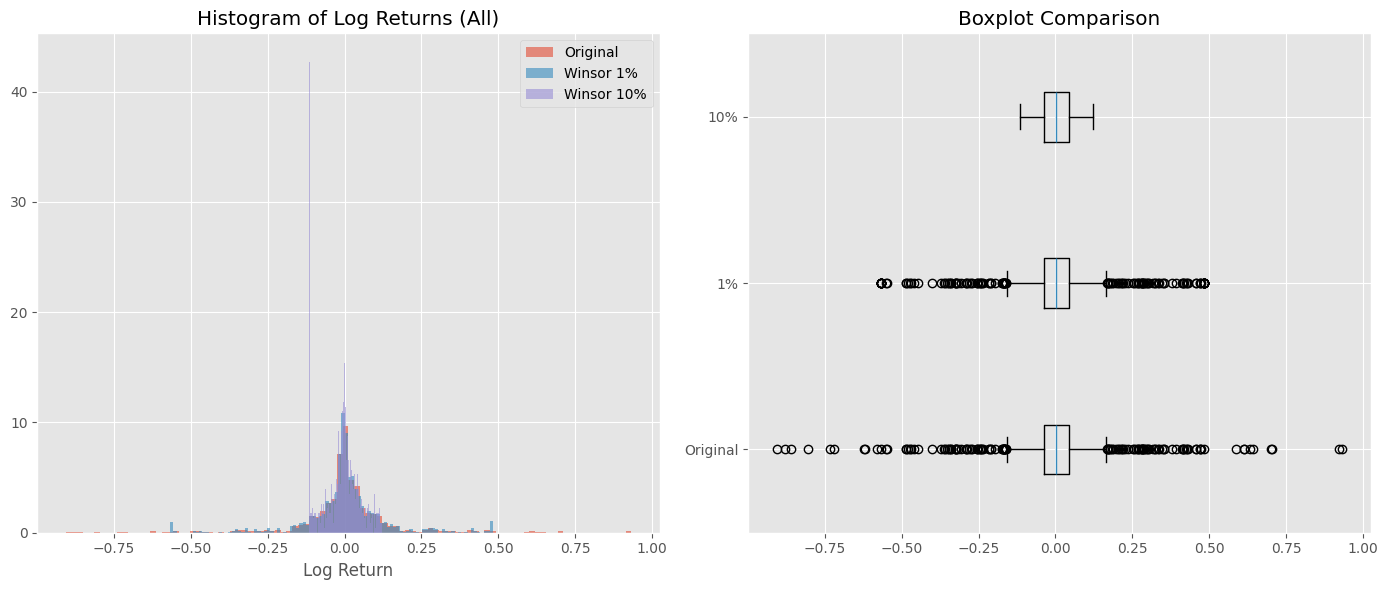

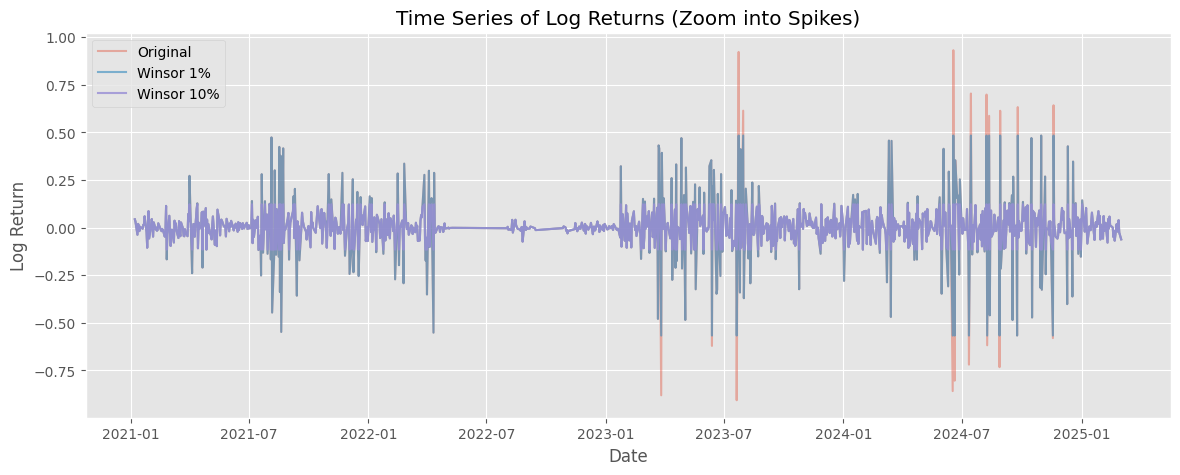

------ Skewness ------
Original   : -0.2256352997133147
Winsor 1%  : -0.316203210233094
Winsor 10% : 0.019717220616182193

------ Kurtosis ------
Original   : 9.371563200617002
Winsor 1%  : 4.948793292168652
Winsor 10% : -0.6408398695017969

------ Clipped Values Count ------
Winsor 1%  : 18 values changed
Winsor 10% : 190 values changed


In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# === Inputs ===
original = log_returns
clip_01 = pd.Series(winsorize(log_returns, limits=[0.01,0.01]), index=log_returns.index)
clip_001 = pd.Series(winsorize(log_returns, limits=[0.1,0.1]), index=log_returns.index)

# === 1. Histogram Comparison ===
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.hist(original, bins=100, alpha=0.6, label='Original', density=True)
plt.hist(clip_01, bins=100, alpha=0.6, label='Winsor 1%', density=True)
plt.hist(clip_001, bins=100, alpha=0.6, label='Winsor 10%', density=True)
plt.legend()
plt.title('Histogram of Log Returns (All)')
plt.xlabel('Log Return')

plt.subplot(1, 2, 2)
plt.boxplot([original, clip_01, clip_001], vert=False, labels=['Original', '1%', '10%'])
plt.title('Boxplot Comparison')

plt.tight_layout()
plt.show()

# === 2. Time Series Comparison ===
plt.figure(figsize=(14, 5))
plt.plot(original.index, original, label='Original', alpha=0.4)
plt.plot(clip_01.index, clip_01, label='Winsor 1%', alpha=0.6)
plt.plot(clip_001.index, clip_001, label='Winsor 10%', alpha=0.8)
plt.legend()
plt.title('Time Series of Log Returns (Zoom into Spikes)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.show()

# === 3. Skewness and Kurtosis ===
print("------ Skewness ------")
print("Original   :", skew(original))
print("Winsor 1%  :", skew(clip_01))
print("Winsor 10% :", skew(clip_001))

print("\n------ Kurtosis ------")
print("Original   :", kurtosis(original))
print("Winsor 1%  :", kurtosis(clip_01))
print("Winsor 10% :", kurtosis(clip_001))

# === 4. Count of Clipped Values ===
clipped_vals_01 = (original != clip_01).sum()
clipped_vals_001 = (original != clip_001).sum()

print("\n------ Clipped Values Count ------")
print(f"Winsor 1%  : {clipped_vals_01} values changed")
print(f"Winsor 10% : {clipped_vals_001} values changed")


In [166]:
skew(original)

-0.2256352997133147

In [169]:
skew(equity2.Total.pct_change().dropna())

2.55775107915951

In [163]:
log_returns.reindex(range(0, len(log_returns)), method='ffill')

TypeError: Cannot compare dtypes datetime64[ns] and int64